# Study Group3 Embedding

## 套件

In [1]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch

from matplotlib.font_manager import fontManager
import plotly.express as px

sns.set_style("darkgrid")

## 1. 文字前處理

Dcard研究所版資料集                            
時間：2025/01/01 - 2025/04/27

In [2]:
dcard = pd.read_csv("ProjectData/dcard_20250101-20250427.csv")

In [3]:
dcard.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,graduate_school,0,NaN,F,國立政治大學
1,2,Dcard,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:55:55,研究所選擇,想問大家如果中興材料、中山材光、台科應科都上了你們會選哪一間\nhttps://sticke...,graduate_school,13,NaN,F,國立臺灣科技大學
2,3,Dcard,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:54:42,中興會研所 放棄請益,此篇文章為轉貼文章，請更新至最新版本觀看完整內容。,graduate_school,1,NaN,M,國立彰化師範大學


In [4]:
len(dcard)

8325

In [5]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
jieba.load_userdict('./dict/user_dict.txt')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from c:\Users\User\Desktop\VSCode_Workspace\Python\SM\SMA_2025S\Project_3\dict\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.u729592c1f8dc564972302061dd9fe8ee.cache
Loading model cost 0.982 seconds.
Prefix dict has been built successfully.


In [6]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [7]:
# 資料前處理

# 去除一些不需要的欄位
metaData = dcard.drop(['dataSource', 'boardID', 'commentCount', 'department', 'gender', 'school'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData = metaData[metaData['sentence'].apply(lambda x: isinstance(x, str))].copy()
metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData.head(10)

,system_id,artUrl,artDate,artTitle,artContent,sentence,word
0,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,您好,[您好]
1,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,我們是政大廣告系張郁敏老師研究團隊,"[政大, 廣告系, 張郁敏, 老師, 研究, 團隊]"
2,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,目前正在進行一項調查,"[一項, 調查]"
3,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,想要請您觀看廣告影片及回答問題,"[想要, 觀看, 廣告, 影片, 回答]"
4,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,此調查只需分鐘,"[調查, 分鐘]"
5,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,就有機會參加抽獎,"[機會, 參加, 抽獎]"
6,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,本研究訪問對象為歲以上,"[研究, 訪問, 對象]"
7,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,如果您願意參加,[參加]
8,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,請連結下列網址,"[連結, 網址]"
9,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,網址,[網址]


In [8]:
print("資料筆數:", len(metaData))

資料筆數: 127937


## 2. Word2Vec

In [9]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,system_id,artUrl,artDate,artTitle,artContent,sentence,word,word_list_bigrams
0,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,您好,[您好],[您好]
1,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,我們是政大廣告系張郁敏老師研究團隊,"[政大, 廣告系, 張郁敏, 老師, 研究, 團隊]","[政大, 廣告系_張郁敏, 老師, 研究, 團隊]"
2,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,目前正在進行一項調查,"[一項, 調查]","[一項, 調查]"
3,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,想要請您觀看廣告影片及回答問題,"[想要, 觀看, 廣告, 影片, 回答]","[想要, 觀看, 廣告, 影片, 回答]"
4,1,https://www.dcard.tw/f/graduate_school/p/25776...,2025-01-15 14:14:32,#學術問卷 張郁敏老師國科會計畫問卷,您好，我們是政大廣告系張郁敏老師研究團隊， \n目前正在進行一項調查，想要請您觀看廣告影片及...,此調查只需分鐘,"[調查, 分鐘]","[調查, 分鐘]"


In [10]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [11]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 47714


['教授', '時間', '老師', '題目', '研究', '考試', '真的', '面試', '學校', '請問']

In [12]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 127937
average length of sentences: 4.077389652719698


### Word2Vec 計算

In [13]:
%env PYTHONHASHSEED=2025

env: PYTHONHASHSEED=2025


In [14]:
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 16


In [15]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

查看結果

In [ ]:
w2v_model.wv.most_similar('教授',topn=10)

[('實驗室', 0.7553578615188599),
 ('老師', 0.7184092998504639),
 ('面談', 0.6459323763847351),
 ('指導教授', 0.6330747008323669),
 ('寄信', 0.6165795922279358),
 ('一位', 0.5781271457672119),
 ('風格', 0.5621153116226196),
 ('評價', 0.5606812834739685),
 ('回答', 0.5464353561401367),
 ('風氣', 0.531938910484314)]

與教授最相關的詞包含實驗室、老師、面談、評價等等，顯示學生時常在文章中提到選擇教授時會考量多項因素。

In [22]:
w2v_model.wv.most_similar('放榜',topn=10)

[('考完', 0.756623387336731),
 ('二階', 0.7490811944007874),
 ('公布', 0.7305058836936951),
 ('沒想到', 0.7213373780250549),
 ('等待', 0.7041778564453125),
 ('一階', 0.7012403607368469),
 ('推甄', 0.6860736608505249),
 ('昨天', 0.6813191771507263),
 ('沒上', 0.6790903806686401),
 ('名額', 0.6754878163337708)]

放榜語意最相近的詞，多與升學考試流程與情緒反應相關，顯示出學生在放榜期間的經歷與心情狀態，包含流程焦慮、結果反應與討論重點

In [ ]:
w2v_model.wv.most_similar(['資管','落榜'],topn=10)

[('資工', 0.8918429613113403),
 ('甲組', 0.8853704333305359),
 ('工工', 0.8788183927536011),
 ('中央', 0.87423175573349),
 ('機械', 0.8734152317047119),
 ('乙組', 0.870850682258606),
 ('電信', 0.8707353472709656),
 ('經管', 0.8678238391876221),
 ('企研', 0.8632793426513672),
 ('清交', 0.8591585159301758)]

「資管」+「落榜」語意相近的詞，結果反映出學生在討論落榜資管系時的常見比較對象或備選方案，結果反映出學生在討論落榜資管系時的常見比較對象或備選方案，可能許多學生會選擇資工以及資管一起考，這顯示出兩者在學生心中具有高度的相關性。

In [30]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['台大','交大'],topn=10)

[('購買', 0.508388876914978),
 ('工具', 0.4461105167865753),
 ('線上', 0.4384077489376068),
 ('持續', 0.4376583993434906),
 ('記錄', 0.4342939555644989),
 ('過的', 0.42897263169288635),
 ('社群', 0.4255159795284271),
 ('情緒', 0.4201357066631317),
 ('夥伴', 0.41574329137802124),
 ('時段', 0.4084504246711731)]

In [47]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("台大","落榜")

0.74911404

In [48]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("中山","落榜")

0.8023247

In [50]:
w2v_model.wv.doesnt_match(["台大", "中央", "中山", "中興", "中正"])

'台大'

In [45]:
# 相對關係
w2v_model.wv.most_similar(positive=["中山"], negative=["台大"], topn=5)

[('北科', 0.41212156414985657),
 ('光電', 0.40799418091773987),
 ('高科', 0.4073181450366974),
 ('電機', 0.4071444869041443),
 ('先進', 0.4000933766365051)]

In [51]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

視覺化字之間的關係及將字做分群

In [52]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat


In [53]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)

In [54]:
getVecs(w2v_model,['台大','中山'])

array([[-8.77199322e-02,  1.64501406e-02, -5.46986386e-02,
         3.05936653e-02,  1.45053238e-01, -1.78431466e-01,
         4.12167221e-01, -4.77434881e-02,  3.35328281e-01,
        -1.63946450e-01, -1.47201434e-01,  3.30953181e-01,
        -1.08324639e-01,  9.60322022e-02, -5.31535745e-02,
         6.88736141e-02, -1.82687506e-01, -2.99920775e-02,
         5.15415706e-03,  1.52768523e-01, -1.71254337e-01,
         2.48967856e-01,  4.20202881e-01, -1.86053574e-01,
        -3.24069671e-02, -9.12673622e-02,  1.69645965e-01,
         1.06317729e-01,  3.61738168e-02,  3.64090413e-01,
        -2.72644669e-01, -3.71916480e-02, -2.18338380e-03,
         3.87918130e-02, -3.53085786e-01, -3.21437269e-02,
        -6.06023036e-02,  2.33582765e-01,  1.76431984e-01,
         1.02127023e-01,  3.67481977e-01, -4.46832955e-01,
         6.96235672e-02,  1.63666513e-02,  6.17955886e-02,
         7.44516313e-01, -2.72756100e-01,  3.41749936e-01,
         1.74516290e-01, -7.03042373e-02, -6.48198426e-0

In [55]:
# 擴展相似的字詞
def expandPosWord(model, words:list, top_n:int, split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])

    return list(set(expand))


In [57]:
expandPosWord(w2v_model,['台大','中山'],top_n = 10)

['企研',
 '台科',
 '國貿',
 '落榜',
 '財金',
 '商研',
 '乙組',
 '中興',
 '臺大',
 '北科',
 '中央',
 '化學',
 '交大',
 '工科',
 '成大',
 '國企',
 '一階',
 '甲組']

In [58]:
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()

# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [59]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [60]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

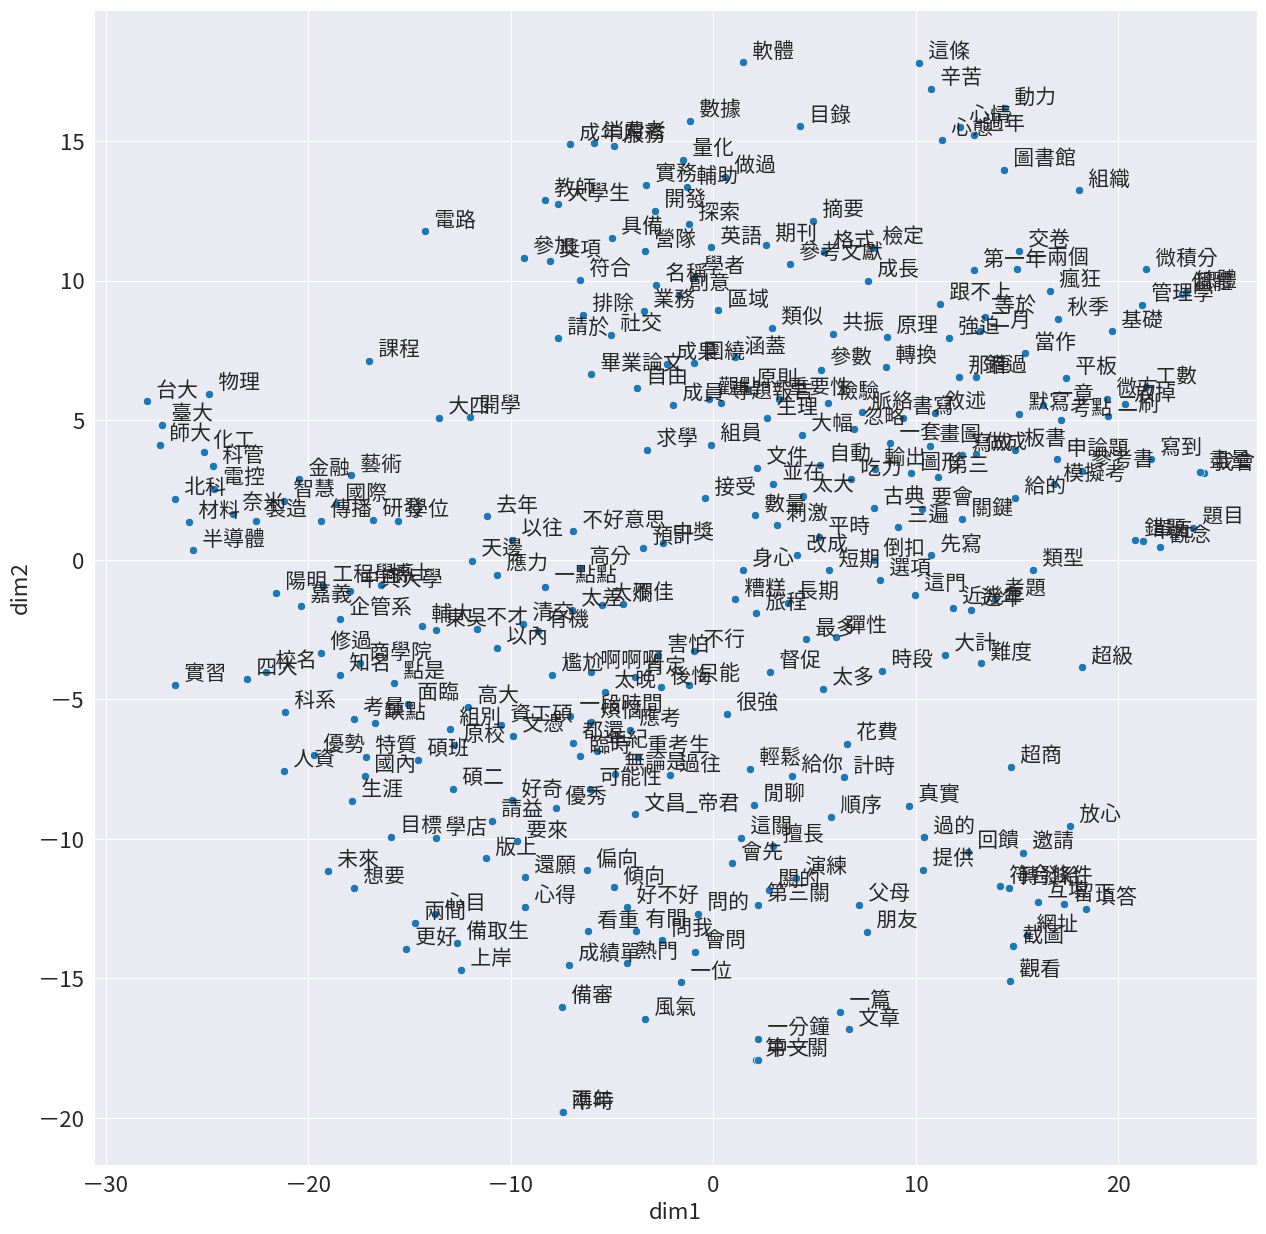

In [61]:
plotScatter(word_df)

- 右上區域反映學習壓力與成績，詞彙如：「辛苦」「動力」「小壓力」「圖書館」「組織」「微積分」「考古題」
- 中間上方區域顯示學生撰寫論文的相關詞彙，如「期刊」「實驗」「目錄」「參考」「摘要」「格式」「數據」
- 左邊中間區域顯示學校與校系選擇，如「台大」「師大」「化工」「電控」「北科」「材料」「半導體」

In [62]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


In [63]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result

In [64]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

- 藍色區域多為與「數理相關科目」或「金融相關科目」相關的詞彙，語意上聚焦於學術學科，其中包含工數、微積分、總體、個體、檢定等。
- 紫色區域多為與「升學志願、校系選擇」相關的詞彙，其中提到台大、北科、師大、電控、化工、材料、科管、資工碩，這些顯示出具代表性的校系與熱門科目，是學生討論升學落點時常見詞彙。
- 黃色區域多為「填問卷」相關詞彙，這些詞多出現在與填寫表單、參與調查、行政回饋與研究問卷有關的語境中，其包含對象，如學生、教師、消費者、成人；填問卷獎勵，如獎項、超商；以及描述問卷發放與填寫行為，如邀請、互填、轉發給、觀看。
- 橘色區域的內容多為與「論文寫作」或「升學」相關的詞彙，論文寫作包含的詞彙，如文獻、文書、參考文獻、期刊、數據、格式、摘要等；升學包含的相關詞彙，如高分、文昌_帝君、重考生、備審等。

## Embedding

In [65]:
from sentence_transformers import SentenceTransformer, models, util

In [66]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


0

In [68]:
df_similar = dcard[['system_id','artTitle', 'artContent']]
# 處理 NaN 或非字串的情況
df_similar['artContent'] = df_similar['artContent'].apply(
    lambda x: re.sub('[^\u4e00-\u9fff]+', '', x) if isinstance(x, str) else ''
)

df_similar.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_16836\599420023.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,system_id,artTitle,artContent
0,1,#學術問卷 張郁敏老師國科會計畫問卷,您好我們是政大廣告系張郁敏老師研究團隊目前正在進行一項調查想要請您觀看廣告影片及回答問題此調...
1,2,研究所選擇,想問大家如果中興材料中山材光台科應科都上了你們會選哪一間
2,3,中興會研所 放棄請益,此篇文章為轉貼文章請更新至最新版本觀看完整內容
3,4,碩士論文排版,不確定這樣的資訊能不能發在這邊如有違規我會立即刪除因為好像有點涉及商業跟交易但我是真心想要為...
4,5,❗填問卷抽電影票、超商禮券500元❗,哈囉大家好我是目前就讀政大傳播學院的研究生也是個嘉義囡仔正在進行我的碩論研究想了解嘉義市影城...


In [69]:
print(torch.__version__)
print(torch.version.cuda)

2.4.1+cu124
12.4


In [70]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device='cuda')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


0

In [71]:
corpus_embeddings = bert_ch.encode(
    df_similar['artContent'],
    convert_to_tensor=True,
    batch_size=32
)

c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning:

1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)



### 查看embedding結果

In [75]:
query_num = 89 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: 跪求企研財金統計考古題

 資料集中前五相似的文章:
跪求企研財金統計考古題 (Score: 1.0000)
財金經研所考古題詳解交換 (Score: 0.9558)
#徵 企研考古題 (Score: 0.9493)
求113經研所個總體考古題詳解 (Score: 0.9428)
徵求政大財政、交大財金考古題解答 (Score: 0.9393)






文章主題為查找企研財金系之考古題，查找內容也大部分為相關科系的考古題。

In [79]:
query_num = 96

top_k = 5

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: 清大114學年度碩士班甄試第11次備取遞補名單

 資料集中前五相似的文章:
清大114學年度碩士班甄試第11次備取遞補名單 (Score: 1.0000)
清大114學年度碩士班甄試第9次備取遞補名單 (Score: 0.9853)
清大114學年度碩士班甄試第10次備取遞補名單 (Score: 0.9853)
清大114學年度碩士班考試第5次備取遞補名單 (Score: 0.9546)
國立臺灣師範大學114學年度技職教育數位碩士在職專班現正招生中！ (Score: 0.9321)






# Classification

In [ ]:
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sentence_transformers import SentenceTransformer, models, util

In [ ]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device='cuda')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


0

引入的資料集為
- Dcard：研究所版
- PTT：科技工作版、軟體工作版 


總資料筆數為3864

In [ ]:
df = pd.read_csv('classification_data/graduate_tech_softjob.csv')

In [ ]:
len(df)

3864

In [ ]:
df

,artContent,artUrl,Label
0,您好我們是政大廣告系張郁敏老師研究團隊目前正在進行一項調查想要請您觀看廣告影片及回答問題此調...,https://www.dcard.tw/f/graduate_school/p/25776...,graduate
1,想問大家如果中興材料中山材光台科應科都上了你們會選哪一間,https://www.dcard.tw/f/graduate_school/p/25776...,graduate
2,此篇文章為轉貼文章請更新至最新版本觀看完整內容,https://www.dcard.tw/f/graduate_school/p/25776...,graduate
3,不確定這樣的資訊能不能發在這邊如有違規我會立即刪除因為好像有點涉及商業跟交易但我是真心想要為...,https://www.dcard.tw/f/graduate_school/p/25777...,graduate
4,哈囉大家好我是目前就讀政大傳播學院的研究生也是個嘉義囡仔正在進行我的碩論研究想了解嘉義市影城...,https://www.dcard.tw/f/graduate_school/p/25776...,graduate
...,...,...,...
3859,這真的窮人的思維什麼是浪費你現在寫的程式按以前的寫法隨便一個就夠你寫一個星期了但你現在隨便拉...,https://www.ptt.cc/bbs/Soft_Job/M.1745900730.A...,softjob
3860,前面有一篇講得很對沒有時代寫程式更屌比有時代還屌因為只能跑書店要讀很多紙本的書才有辦法做出程...,https://www.ptt.cc/bbs/Soft_Job/M.1745934477.A...,softjob
3861,如題最近在學習這個但網路上的資料好像蠻滿少的不知道可以往什麼方向找資料來學習以及這個作用就是...,https://www.ptt.cc/bbs/Soft_Job/M.1745934622.A...,softjob
3862,所以我說你們這些小朋友沒搞清楚程式語言的最終目標上一篇我提供出一個製作中文程式語言的想法是要...,https://www.ptt.cc/bbs/Soft_Job/M.1745975132.A...,softjob


In [ ]:
df = df.dropna(subset=['artContent'])

In [ ]:
len(df)

3848

## 使用 bert-base-chinese Embedding模型進行分類任務

In [ ]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device='cuda')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


0

In [ ]:
df = df.rename(columns={
    'artContent': 'content'
})

In [ ]:
df

,content,artUrl,Label
0,您好我們是政大廣告系張郁敏老師研究團隊目前正在進行一項調查想要請您觀看廣告影片及回答問題此調...,https://www.dcard.tw/f/graduate_school/p/25776...,graduate
1,想問大家如果中興材料中山材光台科應科都上了你們會選哪一間,https://www.dcard.tw/f/graduate_school/p/25776...,graduate
2,此篇文章為轉貼文章請更新至最新版本觀看完整內容,https://www.dcard.tw/f/graduate_school/p/25776...,graduate
3,不確定這樣的資訊能不能發在這邊如有違規我會立即刪除因為好像有點涉及商業跟交易但我是真心想要為...,https://www.dcard.tw/f/graduate_school/p/25777...,graduate
4,哈囉大家好我是目前就讀政大傳播學院的研究生也是個嘉義囡仔正在進行我的碩論研究想了解嘉義市影城...,https://www.dcard.tw/f/graduate_school/p/25776...,graduate
...,...,...,...
3859,這真的窮人的思維什麼是浪費你現在寫的程式按以前的寫法隨便一個就夠你寫一個星期了但你現在隨便拉...,https://www.ptt.cc/bbs/Soft_Job/M.1745900730.A...,softjob
3860,前面有一篇講得很對沒有時代寫程式更屌比有時代還屌因為只能跑書店要讀很多紙本的書才有辦法做出程...,https://www.ptt.cc/bbs/Soft_Job/M.1745934477.A...,softjob
3861,如題最近在學習這個但網路上的資料好像蠻滿少的不知道可以往什麼方向找資料來學習以及這個作用就是...,https://www.ptt.cc/bbs/Soft_Job/M.1745934622.A...,softjob
3862,所以我說你們這些小朋友沒搞清楚程式語言的最終目標上一篇我提供出一個製作中文程式語言的想法是要...,https://www.ptt.cc/bbs/Soft_Job/M.1745975132.A...,softjob


In [ ]:
df["embeddings"] = df["content"].apply(
    lambda x: bert_ch.encode(x) if isinstance(x, str) else None
)


c:\Users\User\anaconda3\envs\sm_new\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [ ]:
import numpy as np
from ast import literal_eval

將訓練集以及測試集以7:3的比例進行切分

In [ ]:
data = df.copy()

X = data["embeddings"].apply(pd.Series)
y = data["Label"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

           0         1         2         3         4         5         6    \
3038  0.585334 -0.175041 -0.157785  0.119658 -0.230060 -0.239857 -0.017099   
2339  0.531968 -0.056803 -0.591627  0.012481  0.040651 -0.234697  0.073038   
2842  0.909369 -0.260184  0.131783  0.448909 -0.185889 -0.399488 -0.146622   
1811  0.755504  0.065260 -0.099188  0.303013 -0.081815 -0.543490  0.000289   
3210  0.461746  0.002710 -0.334146  0.043480 -0.213752 -0.324670 -0.036142   

           7         8         9    ...       758       759       760  \
3038 -0.384666 -0.216667 -0.179887  ... -0.027361 -0.049833  0.338184   
2339 -0.275114 -0.159473 -0.403385  ...  0.324449  0.008125  0.209842   
2842 -0.055094  0.246722 -0.290948  ...  0.141078 -0.019427  0.230086   
1811 -0.195169 -0.338885 -0.496776  ... -0.070605  0.005167  0.421076   
3210  0.066870 -0.046056 -0.265670  ...  0.062530 -0.275571  0.292265   

           761       762       763       764       765       766       767  
3038  0.242562 

使用4種的分類模型進行比較，其中包含：
- Logistic Regression（邏輯迴歸）
- Decision Tree（決策樹）
- Random Forest（隨機森林）
- SVM（支援向量機）

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report

# 定義模型組
model_set = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': svm.SVC(probability=True)
}

# 執行訓練、預測與報告輸出
for name, model in model_set.items():
    print("=" * 100)
    print(f"Training and evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # 輸出評估報告
    print(classification_report(y_test, y_pred))
    print("=" * 100)


Training and evaluating: Logistic Regression
              precision    recall  f1-score   support

    graduate       0.95      0.92      0.93       412
     softjob       0.83      0.84      0.83       359
     techjob       0.84      0.86      0.85       384

    accuracy                           0.87      1155
   macro avg       0.87      0.87      0.87      1155
weighted avg       0.87      0.87      0.87      1155

Training and evaluating: Decision Tree
              precision    recall  f1-score   support

    graduate       0.83      0.75      0.78       412
     softjob       0.62      0.71      0.66       359
     techjob       0.71      0.69      0.70       384

    accuracy                           0.72      1155
   macro avg       0.72      0.72      0.72      1155
weighted avg       0.72      0.72      0.72      1155

Training and evaluating: Random Forest
              precision    recall  f1-score   support

    graduate       0.89      0.92      0.91       412
     s

結果Logistic Regression和SVM為最佳模型，兩者表現相當，而Decision Tree表現則為最差之模型。      

-------------------------------------------------------------------------------------------------------            

Logistic Regression與SVM在softjob分類結果之比較：
- Logistic Regression的precision較高，表示對softjob的預測較少誤判。
- SVM的recall較高，表示它比較不易漏掉softjob類別的資料。
- 以f1-score來說，兩者差異較小，表現相當接近。
-------------------------------------------------------------------------------------------------------      

Logistic Regression與SVM在techjob分類結果之比較：
- SVM 的precision較高，預測為techjob的樣本，大多真的屬於techjob。
- Logistic Regression的recall 較高，表示對techjob的樣本識別力更好。
- f1-score 相當，在 techjob上兩者的表現同樣相當接近。

## 使用 bge-m3 Embedding模型進行分類任務
北京智源研究院開發的多語言embedding模型，其支援超過100種語言。

In [ ]:
df_bge = pd.read_csv('classification_data/graduate_tech_softjob.csv')

In [ ]:
df_bge = df_bge.dropna(subset=['artContent'])

In [ ]:
df_bge.head(2)

,artContent,artUrl,Label
0,您好我們是政大廣告系張郁敏老師研究團隊目前正在進行一項調查想要請您觀看廣告影片及回答問題此調...,https://www.dcard.tw/f/graduate_school/p/25776...,graduate
1,想問大家如果中興材料中山材光台科應科都上了你們會選哪一間,https://www.dcard.tw/f/graduate_school/p/25776...,graduate


In [ ]:
from sentence_transformers import SentenceTransformer

# 載入中文 embedding 模型
bgeModel = SentenceTransformer("BAAI/bge-m3", device='cuda')
bgeModel.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# 取得 embeddings
df_bge["embeddings"] = df_bge["artContent"].apply(
    lambda x: bgeModel.encode(x) if isinstance(x, str) else None
)

In [ ]:
data = df_bge.copy()

X_bge = data["embeddings"].apply(pd.Series)
y_bge = data["Label"]

X_train_bge, X_test_bge, y_train_bge, y_test_bge = train_test_split(
    X_bge, y_bge, test_size=0.3, random_state=777
)

In [ ]:
# 定義模型組
model_set = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': svm.SVC(probability=True)
}

for name, model in model_set.items():
    print("=" * 100)
    print(f"Training and evaluating: {name}")
    model.fit(X_train_bge, y_train_bge)
    y_pred_bge = model.predict(X_test_bge)
    y_pred_proba_bge = model.predict_proba(X_test_bge)

    # 輸出評估報告
    print(classification_report(y_test_bge, y_pred_bge))
    print("=" * 100)

Training and evaluating: Logistic Regression
              precision    recall  f1-score   support

    graduate       0.92      0.95      0.94       412
     softjob       0.87      0.82      0.84       359
     techjob       0.86      0.86      0.86       384

    accuracy                           0.88      1155
   macro avg       0.88      0.88      0.88      1155
weighted avg       0.88      0.88      0.88      1155

Training and evaluating: Decision Tree


              precision    recall  f1-score   support

    graduate       0.80      0.78      0.79       412
     softjob       0.62      0.58      0.60       359
     techjob       0.62      0.67      0.64       384

    accuracy                           0.68      1155
   macro avg       0.68      0.68      0.68      1155
weighted avg       0.68      0.68      0.68      1155

Training and evaluating: Random Forest
              precision    recall  f1-score   support

    graduate       0.90      0.94      0.92       412
     softjob       0.82      0.83      0.82       359
     techjob       0.86      0.82      0.84       384

    accuracy                           0.86      1155
   macro avg       0.86      0.86      0.86      1155
weighted avg       0.86      0.86      0.86      1155

Training and evaluating: SVM
              precision    recall  f1-score   support

    graduate       0.94      0.95      0.95       412
     softjob       0.86      0.84      0.85       359
     te

同樣以SVM和Logistic Regression上表現最為出色，而Decision Tree表現同為最差之模型。 

BGE-M3在softjob和techjob預測更穩定，f1-score 更高。                 
總結來說，SVM在BGE-M3中表現最佳，其fl-score具有最好的表現。

# GROUP4：BERT (Encoder-only-model)

### 大綱：
1. 套件介紹
2. 資料前處理
3. Token classification<br>
  3.1 NER<br>
4. Sequence classification<br>
  4.1 Sentiment Classification<br>
  4.2 Relation Extraction (RE)<br>
5. Text Clustering<br>
  5.1 BERTopic 基本用法介紹<br>
  5.2 BERTopic 的 Embedding model<br>
  5.3 BERTopic 的 Clustering model<br>
  5.4 套用中文資料<br>
  5.5 使用Representation方法去微調主題表示



### 1. 套件

In [ ]:
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
from wordcloud import WordCloud

# 設定字體
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

**Transformers 和 Sentence-transformers （使用 huggingface 模型）**

In [ ]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

**BERTopic套件**

In [ ]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

### 2. 資料前處理

使用DCARD研究所版資料集                              
時間範圍從2025/01/01 - 2025/04/29

In [ ]:
origin_data = pd.read_csv('../dcard_graduate_20250101-20250429.csv')

In [ ]:
origin_data.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,虎科自動化工程教授,我是碩士推徵入校的學生 \n想問一下哪位老師比較常接業界的案子？ \n或是比較常有研討會等等...,graduate_school,1,cyur552,F,Ruby
1,2,Dcard,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:02:47,研究所推甄諮詢協助,114年已經協助很多位推甄考生上岸🔥有需要備審製作、精修或是對再來推甄跟面試有疑問都可以私訊...,graduate_school,6,fuckubitch222,M,Xcc14471
2,3,Dcard,https://www.dcard.tw/f/graduate_school/p/25809...,2025-02-24 15:16:58,私立資工推甄詢問,現在小妹 就讀上面這間資工現在大二 請問趴數30% 有機會推甄嗎 可以推到哪裡呢？不是很想考...,graduate_school,10,NaN,F,元智大學


In [ ]:
len(origin_data)

4273

In [ ]:
origin_data = origin_data.dropna(subset=['artContent']).reset_index(drop=True)

In [ ]:
len(origin_data)

4269

資料清理

In [ ]:
# 去除一些不需要的欄位
metaData = origin_data.drop(['dataSource', 'boardID', 'commentCount', 'department', 'gender', 'school'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData = metaData[metaData['sentence'].notna()]  # 去除 NaN
metaData = metaData[metaData['sentence'].str.strip() != ""]  # 去除空字串或全空白
metaData = metaData.reset_index(drop=True)

metaData.head(10)

,system_id,artUrl,artDate,artTitle,artContent,sentence
0,1,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,虎科自動化工程教授,我是碩士推徵入校的學生 \n想問一下哪位老師比較常接業界的案子？ \n或是比較常有研討會等等...,我是碩士推徵入校的學生想問一下哪位老師比較常接業界的案子
1,1,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,虎科自動化工程教授,我是碩士推徵入校的學生 \n想問一下哪位老師比較常接業界的案子？ \n或是比較常有研討會等等...,或是比較常有研討會等等再麻煩各位同學回覆謝謝
2,2,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:02:47,研究所推甄諮詢協助,114年已經協助很多位推甄考生上岸🔥有需要備審製作、精修或是對再來推甄跟面試有疑問都可以私訊...,年已經協助很多位推甄考生上岸有需要備審製作精修或是對再來推甄跟面試有疑問都可以私訊我
3,2,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:02:47,研究所推甄諮詢協助,114年已經協助很多位推甄考生上岸🔥有需要備審製作、精修或是對再來推甄跟面試有疑問都可以私訊...,擬推薦信也沒問題歡迎找我聊聊
4,2,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:02:47,研究所推甄諮詢協助,114年已經協助很多位推甄考生上岸🔥有需要備審製作、精修或是對再來推甄跟面試有疑問都可以私訊...,聊聊不用錢
5,3,https://www.dcard.tw/f/graduate_school/p/25809...,2025-02-24 15:16:58,私立資工推甄詢問,現在小妹 就讀上面這間資工現在大二 請問趴數30% 有機會推甄嗎 可以推到哪裡呢？不是很想考...,現在小妹就讀上面這間資工現在大二請問趴數有機會推甄嗎可以推到哪裡呢
6,3,https://www.dcard.tw/f/graduate_school/p/25809...,2025-02-24 15:16:58,私立資工推甄詢問,現在小妹 就讀上面這間資工現在大二 請問趴數30% 有機會推甄嗎 可以推到哪裡呢？不是很想考...,不是很想考試還有除了專題多益還要準備什麼呢
7,3,https://www.dcard.tw/f/graduate_school/p/25809...,2025-02-24 15:16:58,私立資工推甄詢問,現在小妹 就讀上面這間資工現在大二 請問趴數30% 有機會推甄嗎 可以推到哪裡呢？不是很想考...,還是直接去考試哈哈哈哈
8,4,https://www.dcard.tw/f/graduate_school/p/25809...,2025-02-24 15:18:54,中正大學犯罪防治學系碩專班評價,如題，\n本人為社工師有意願就讀中正犯罪防治研究所在職專班\n是否有學長姐能夠分享讀中正犯防...,如題
9,4,https://www.dcard.tw/f/graduate_school/p/25809...,2025-02-24 15:18:54,中正大學犯罪防治學系碩專班評價,如題，\n本人為社工師有意願就讀中正犯罪防治研究所在職專班\n是否有學長姐能夠分享讀中正犯防...,本人為社工師有意願就讀中正犯罪防治研究所在職專班是否有學長姐能夠分享讀中正犯防碩專班的感想


## 3. Token classification

使用 CKIP 開發的 NLP 套件：ckip_transformers<br>
- 使用的 WS 模型：https://huggingface.co/ckiplab/bert-base-chinese-ws<br>
- 使用的 POS 模型：https://huggingface.co/ckiplab/bert-base-chinese-pos<br>
- 使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [ ]:
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=0) # Word Segmenter斷詞
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=0) # POS tagger 詞性標記
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=0) # NER識別

**將CKIP套用到我們先前處理好的資料集**

In [ ]:
# 以前50筆資料作為範例
text = metaData['sentence'].tolist()

# 執行處理 
ws = ws_driver(text) # 斷詞
pos = pos_driver(ws) # POS
ner = ner_driver(text) # NER

# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos) # 確認斷詞和POS的長度相同
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})") # 合併在一起
   return "\u3000".join(res) 

sentences, packed_sentences, entities = [], [], []

# 儲存結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# 將結果存在一個 dataframe 中
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results.head(10)


Inference: 100%|██████████| 355/355 [16:16<00:00,  2.75s/it]


,sentence,packed_sentence,entities
0,我是碩士推徵入校的學生想問一下哪位老師比較常接業界的案子,我(Nh) 是(SHI) 碩士(Na) 推徵(VC) 入校(VA) 的(DE) 學生(Na)...,[]
1,或是比較常有研討會等等再麻煩各位同學回覆謝謝,或是(Caa) 比較(Dfa) 常(D) 有(V_2) 研討會(Na) 等等(Cab) 再(...,[]
2,年已經協助很多位推甄考生上岸有需要備審製作精修或是對再來推甄跟面試有疑問都可以私訊我,年(Na) 已經(D) 協助(VC) 很多(Neqa) 位(Nf) 推甄(Na) 考生(Na...,"[NerToken(word='上岸', ner='GPE', idx=(12, 14))]"
3,擬推薦信也沒問題歡迎找我聊聊,擬(VF) 推薦信(Na) 也(D) 沒(VJ) 問題(Na) 歡迎(VJ) 找(VC) 我...,[]
4,聊聊不用錢,聊聊(VE) 不(D) 用(VC) 錢(Na),[]
5,現在小妹就讀上面這間資工現在大二請問趴數有機會推甄嗎可以推到哪裡呢,現在(Nd) 小妹(Na) 就讀(VCL) 上面(Ncd) 這(Nep) 間(Nf) 資工(...,"[NerToken(word='大二', ner='CARDINAL', idx=(14, ..."
6,不是很想考試還有除了專題多益還要準備什麼呢,不(D) 是(SHI) 很(Dfa) 想(VE) 考試(Na) 還(D) 有(V_2) 除了...,[]
7,還是直接去考試哈哈哈哈,還是(D) 直接(VH) 去(VCL) 考試(VA) 哈哈(D) 哈哈(D),[]
8,如題,如(P) 題(Na),[]
9,本人為社工師有意願就讀中正犯罪防治研究所在職專班是否有學長姐能夠分享讀中正犯防碩專班的感想,本人(Nh) 為(P) 社工師(Na) 有(V_2) 意願(Na) 就讀(VCL) 中正(N...,"[NerToken(word='中正犯罪防治研究所', ner='ORG', idx=(11..."


儲存結果

In [ ]:
# ner_results.to_pickle('ner_results.pkl')

讀取結果

In [ ]:
ner_results = pd.read_pickle('ner_results.pkl')

In [ ]:
ner_results.loc[2, 'entities']

["NerToken(word='上岸', ner='GPE', idx=(12, 14))"]

#### NER分析

In [ ]:
all_entities = []

# 遍歷每一列
for _, row in ner_results.iterrows():
    sentence = row['sentence']
    entity_list = row['entities']
    
    # 如果 entity_list 是有效的 list
    if isinstance(entity_list, list):
        for ent in entity_list:
            match = re.match(r"NerToken\(word='(.*?)', ner='(.*?)', idx=\((\d+), (\d+)\)\)", ent)
            if match:
                word, ner, idx_start, idx_end = match.groups()
                all_entities.append({
                    'sentence': sentence,
                    'word': word,
                    'ner': ner,
                    'idx': (int(idx_start), int(idx_end))
                })

# 建立展平後的 DataFrame
entities_df = pd.DataFrame(all_entities)

In [ ]:
entities_df

,sentence,word,ner,idx
0,年已經協助很多位推甄考生上岸有需要備審製作精修或是對再來推甄跟面試有疑問都可以私訊我,上岸,GPE,"(12, 14)"
1,現在小妹就讀上面這間資工現在大二請問趴數有機會推甄嗎可以推到哪裡呢,大二,CARDINAL,"(14, 16)"
2,本人為社工師有意願就讀中正犯罪防治研究所在職專班是否有學長姐能夠分享讀中正犯防碩專班的感想,中正犯罪防治研究所,ORG,"(11, 20)"
3,先放結論只放有錄取備取的臺大生醫電子備取沒上,臺大,ORG,"(12, 14)"
4,差一點點清大電機乙備取沒上清大工學院聯招逕取最後選這邊,清大,ORG,"(4, 6)"
...,...,...,...,...
32367,已經在大二末期有加入某教授的實驗室了,大二末期,DATE,"(3, 7)"
32368,並且在其暑假有完成一個小實驗,暑假,DATE,"(4, 6)"
32369,並且在其暑假有完成一個小實驗,一,CARDINAL,"(9, 10)"
32370,現在已經是大三的寒假了,大三,DATE,"(5, 7)"


In [ ]:
entities_df['ner'].unique()

array(['GPE', 'CARDINAL', 'ORG', 'DATE', 'FAC', 'QUANTITY', 'PERSON',
       'LANGUAGE', 'TIME', 'ORDINAL', 'NORP', 'EVENT', 'WORK_OF_ART',
       'PERCENT', 'LOC', 'MONEY', 'LAW', 'PRODUCT'], dtype=object)

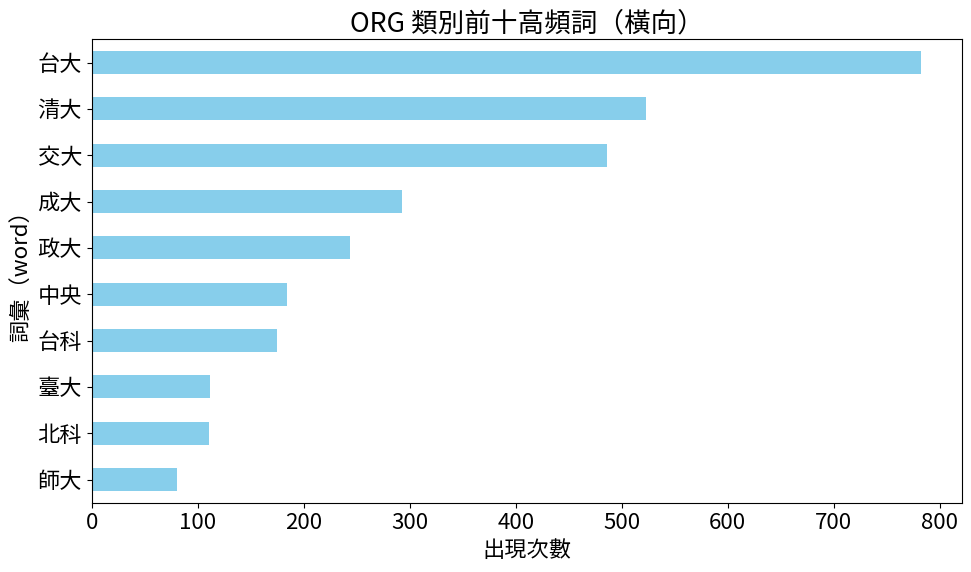

In [ ]:
import matplotlib.pyplot as plt

# 取得 ORG 類別中出現頻率前 10 的詞
top_org_words = (
    entities_df[entities_df['ner'] == 'ORG']['word']
    .value_counts()
    .head(10)
)

# 畫出橫向長條圖
plt.figure(figsize=(10, 6))
top_org_words.plot(kind='barh', color='skyblue')

plt.title("ORG 類別前十高頻詞（橫向）")
plt.xlabel("出現次數")
plt.ylabel("詞彙（word）")
plt.gca().invert_yaxis()  # 讓最多的排在最上面
plt.tight_layout()
plt.show()

台大、清大、交大、成大、政大為最常被提到的五所學校，這五所學校為台灣的頂大，為考研學生的首要目標。<br>
而台大明顯最高，顯示在研究所相關討論中，台大是最具指標性、也最受申請者關注的學校。。

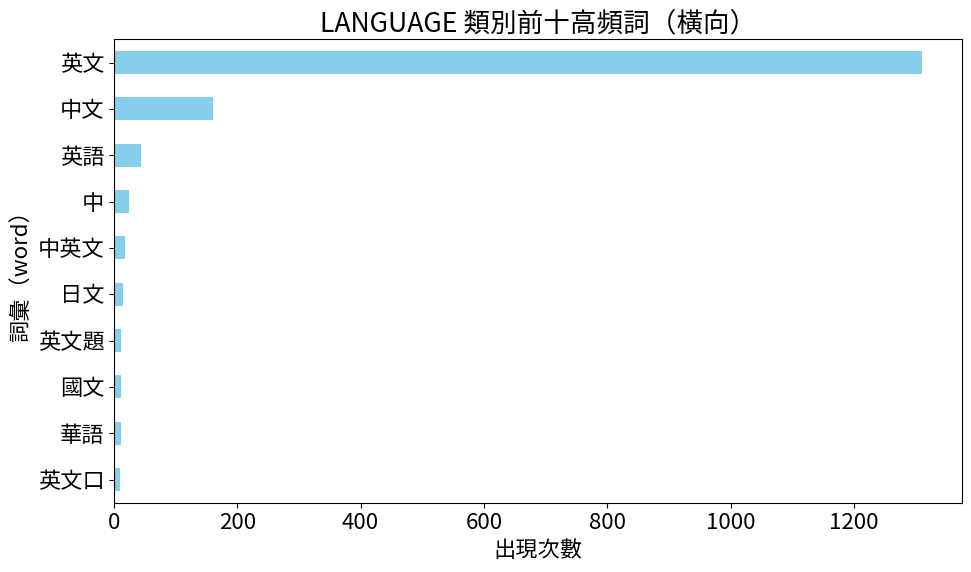

In [ ]:
import matplotlib.pyplot as plt

# 取得 ORG 類別中出現頻率前 10 的詞
top_per_words = (
    entities_df[entities_df['ner'] == 'LANGUAGE']['word']
    .value_counts()
    .head(10)
)

# 畫出橫向長條圖
plt.figure(figsize=(10, 6))
top_per_words.plot(kind='barh', color='skyblue')

plt.title("LANGUAGE 類別前十高頻詞（橫向）")
plt.xlabel("出現次數")
plt.ylabel("詞彙（word）")
plt.gca().invert_yaxis()  # 讓最多的排在最上面
plt.tight_layout()
plt.show()

「英文」壓倒性最高，表示英文在研究所申請中是極其重要的因素，常見內容可能包括：英文面試、英文成績門檻、英文論文等。

## 4. Sentiment Classification

使用 Huggingface 上面已經針對 Sentiment classification 任務 finetune 的 BERT 模型來實作<br>
使用的模型：https://huggingface.co/techthiyanes/chinese_sentiment<br><br>
情緒(start 1到star 5)：<br>
1. Semi-negation<br>
2. Negation<br>
3. Neutral<br>
4. Semi-positive<br>
5. Positive

In [ ]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"  # 你可以將這裡換成你想要使用的模型
model = pipeline('sentiment-analysis', model=model_name, truncation=True, max_length=512)

Device set to use cuda:0


In [ ]:
# 建立一個新的 dataframe 來儲存結果
results_df = pd.DataFrame(columns=['artUrl','artDate','sentence', 'label', 'score'])
results_df['sentence'] = metaData['sentence']
results_df['artUrl'] = metaData['artUrl']
results_df['artDate'] = metaData['artDate']

# 定義一個函數來進行情緒分析
def analyze_sentiment(sentence):
    result = model([sentence])
    return pd.Series([result[0]['label'], result[0]['score']])

# 使用 apply 函數來進行情緒分析
results_df[['label', 'score']] = metaData['sentence'].apply(analyze_sentiment)

# 輸出結果
results_df.head(10)

,artUrl,artDate,sentence,label,score
0,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,我是碩士推徵入校的學生想問一下哪位老師比較常接業界的案子,star 4,0.611464
1,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,或是比較常有研討會等等再麻煩各位同學回覆謝謝,star 4,0.316631
2,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:02:47,年已經協助很多位推甄考生上岸有需要備審製作精修或是對再來推甄跟面試有疑問都可以私訊我,star 5,0.360496
3,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:02:47,擬推薦信也沒問題歡迎找我聊聊,star 4,0.391280
4,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:02:47,聊聊不用錢,star 2,0.304500
5,https://www.dcard.tw/f/graduate_school/p/25809...,2025-02-24 15:16:58,現在小妹就讀上面這間資工現在大二請問趴數有機會推甄嗎可以推到哪裡呢,star 4,0.537423
6,https://www.dcard.tw/f/graduate_school/p/25809...,2025-02-24 15:16:58,不是很想考試還有除了專題多益還要準備什麼呢,star 4,0.477456
7,https://www.dcard.tw/f/graduate_school/p/25809...,2025-02-24 15:16:58,還是直接去考試哈哈哈哈,star 4,0.512078
8,https://www.dcard.tw/f/graduate_school/p/25809...,2025-02-24 15:18:54,如題,star 4,0.537705
9,https://www.dcard.tw/f/graduate_school/p/25809...,2025-02-24 15:18:54,本人為社工師有意願就讀中正犯罪防治研究所在職專班是否有學長姐能夠分享讀中正犯防碩專班的感想,star 4,0.640964


儲存結果

In [ ]:
# results_df.to_pickle('sentiment_results.pkl')

讀取結果

In [ ]:
results_df = pd.read_pickle('sentiment_results.pkl')

In [ ]:
results_df['label'].describe()

count      90802
unique         5
top       star 4
freq       55727
Name: label, dtype: object

In [ ]:
star1_df = results_df[results_df['label'] == 'star 2']
star1_df

,artUrl,artDate,sentence,label,score
4,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:02:47,聊聊不用錢,star 2,0.304500
16,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:05:39,先放結論只放有錄取備取的臺大生醫電子備取沒上,star 2,0.358910
71,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:05:39,卻跟你們一樣無能為力再者,star 2,0.261750
74,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:05:39,絕對處於劣勢,star 2,0.331255
111,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 10:31:06,無相關修課,star 2,0.381028
...,...,...,...,...,...
90641,https://www.dcard.tw/f/graduate_school/p/25770...,2025-01-08 15:15:01,看起來就跟選另一半一樣謹慎,star 2,0.383702
90661,https://www.dcard.tw/f/graduate_school/p/25769...,2025-01-06 16:00:59,請問是直接走進去說想了解考某某研究所的課程這樣就好了嗎,star 2,0.371010
90728,https://www.dcard.tw/f/graduate_school/p/25769...,2025-01-07 04:54:04,有可能放棄的呢,star 2,0.358553
90752,https://www.dcard.tw/f/graduate_school/p/25773...,2025-01-11 10:06:24,還是畫虎爛,star 2,0.430856


### 以文章為單位計算情緒正面或負面

In [ ]:
sentiment_count_by_article = pd.DataFrame(
    results_df.groupby(["artUrl","artDate", "label"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article.head(10)

,artUrl,artDate,label,size
0,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 02:00:58,star 4,8
1,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 02:00:58,star 5,1
2,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 03:43:07,star 5,3
3,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 04:02:35,star 1,1
4,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 04:02:35,star 3,5
5,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 04:02:35,star 4,3
6,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 04:02:35,star 5,2
7,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 04:16:16,star 4,4
8,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 04:16:16,star 5,2
9,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 04:46:26,star 1,1


In [ ]:
sentiment_count_by_article

,artUrl,artDate,label,size
0,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 02:00:58,star 4,8
1,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 02:00:58,star 5,1
2,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 03:43:07,star 5,3
3,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 04:02:35,star 1,1
4,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 04:02:35,star 3,5
...,...,...,...,...
11568,https://www.dcard.tw/f/graduate_school/p/25868...,2025-04-29 17:41:49,star 2,2
11569,https://www.dcard.tw/f/graduate_school/p/25868...,2025-04-29 17:41:49,star 3,1
11570,https://www.dcard.tw/f/graduate_school/p/25868...,2025-04-29 17:41:49,star 4,3
11571,https://www.dcard.tw/f/graduate_school/p/25868...,2025-04-29 18:32:57,star 3,1


計算文章整體偏正面或負面

In [ ]:
sentiment_df = sentiment_count_by_article.copy()

# 解析 star 數字
sentiment_df['star_rating'] = sentiment_df['label'].str.extract(r'star (\d)').astype(int)

# 定義情緒分類規則
def map_sentiment(star):
    if star in [4, 5]:
        return 'positive'
    elif star in [1, 2]:
        return 'negative'
    else:
        return 'neutral'

# 新增 sentiment 欄位
sentiment_df['sentiment'] = sentiment_df['star_rating'].apply(map_sentiment)

# 依照 artUrl 和 sentiment 加總留言數（size）
sentiment_summary = sentiment_df.groupby(['artUrl','artDate', 'sentiment'])['size'].sum().unstack(fill_value=0)

# 確保所有情緒欄位都存在（若缺漏則補零）
for label in ['positive', 'neutral', 'negative']:
    if label not in sentiment_summary.columns:
        sentiment_summary[label] = 0

# 判斷整體情緒傾向
def determine_sentiment(row):
    if row['positive'] > row['negative']:
        return 'Positive'
    elif row['negative'] > row['positive']:
        return 'Negative'
    else:
        return 'Neutral'

# 新增 overall_sentiment 欄位
sentiment_summary['overall_sentiment'] = sentiment_summary.apply(determine_sentiment, axis=1)

# 重設索引，artUrl 變為欄位
sentiment_summary = sentiment_summary.reset_index()

# 顯示結果（可視化用）
sentiment_summary


sentiment,artUrl,artDate,negative,neutral,positive,overall_sentiment
0,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 02:00:58,0,0,9,Positive
1,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 03:43:07,0,0,3,Positive
2,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 04:02:35,1,5,5,Positive
3,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 04:16:16,0,0,6,Positive
4,https://www.dcard.tw/f/graduate_school/p/25764...,2025-01-01 04:46:26,1,6,13,Positive
...,...,...,...,...,...,...
4257,https://www.dcard.tw/f/graduate_school/p/25868...,2025-04-29 15:14:10,18,30,95,Positive
4258,https://www.dcard.tw/f/graduate_school/p/25868...,2025-04-29 16:11:20,3,0,10,Positive
4259,https://www.dcard.tw/f/graduate_school/p/25868...,2025-04-29 16:41:54,2,1,5,Positive
4260,https://www.dcard.tw/f/graduate_school/p/25868...,2025-04-29 17:41:49,3,1,3,Neutral


In [ ]:
sentiment_summary['overall_sentiment'].describe()

count         4262
unique           3
top       Positive
freq          3749
Name: overall_sentiment, dtype: object

計算一天之中有多少正面或負面文章

In [ ]:
import pandas as pd

# 轉換 artDate 為 datetime 格式，並只保留日期（去除時間）
sentiment_summary['artDate'] = pd.to_datetime(sentiment_summary['artDate']).dt.date

# 將 overall_sentiment 映射為中文分類
sentiment_summary['sentiment_class'] = sentiment_summary['overall_sentiment'].map({
    'Positive': '正向',
    'Negative': '負向'
})

# 過濾掉 Neutral 或空值
filtered_df = sentiment_summary.dropna(subset=['sentiment_class'])

# 每天各情緒類別的文章數（以天為單位）
daily_sentiment = (
    filtered_df
    .groupby(['artDate', 'sentiment_class'])['artUrl']
    .count()
    .reset_index(name='size')
)

# 顯示結果
daily_sentiment


,artDate,sentiment_class,size
0,2025-01-01,正向,25
1,2025-01-02,正向,26
2,2025-01-02,負向,1
3,2025-01-03,正向,25
4,2025-01-03,負向,2
...,...,...,...
182,2025-04-27,正向,15
183,2025-04-28,正向,26
184,2025-04-28,負向,4
185,2025-04-29,正向,26


結果如下

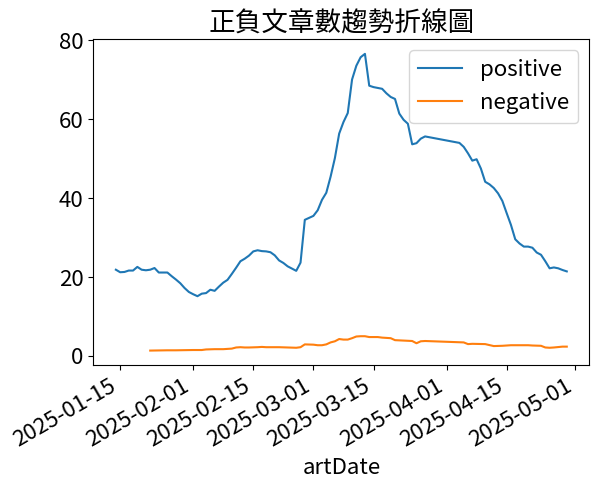

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = daily_sentiment[daily_sentiment["sentiment_class"] == "正向"]
neg = daily_sentiment[daily_sentiment["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖")  # 記得加上才能顯示中文
plt.show()

在2月底快速上升，於3月中旬達到高峰。<br>
研究所相關討論呈現高度正向情緒傾向，尤其集中於放榜階段。<br>
三月中之後呈現下降趨勢，4月中後逐漸回落至20~30篇之間。

| 學校名稱           | 放榜時間                                               |
|--------------------|--------------------------------------------------------|
| 國立台灣大學       | 第一梯：114.03.05<br>第二梯：114.03.19               |
| 台灣聯合大學系統   | 公告：113.03.25                                        |
| 國立台灣科技大學   | 初試放榜：114.02.19<br>複試放榜：114.03.19           |
| 國立清華大學       | 初試放榜：114.03.03<br>複試放榜：114.03.21           |
| 國立陽明交通大學   | 初試放榜：114.03.06<br>複試放榜：114.04.02           |
| 國立政治大學       | 第一梯：114.02.27<br>第二梯：114.03.26               |
| 國立成功大學       | 第一梯：114.02.27<br>第二梯：114.03.28               |
| 國立中山大學       | 一階段：114.02.27<br>二階段：114.03.25               |
| 國立中央大學       | 初試放榜：114.02.27<br>複試放榜：各系所自行公告       |
| 國立中興大學       | 第一梯：114.02.27<br>第二梯：114.03.26               |
| 國立中正大學       | 第一梯：114.03.07<br>第二梯：114.04.11               |

### 以POS斷詞結果繪製正面文字雲

In [ ]:
cloud_pos_df = results_df.copy()
cloud_pos_df['sentence'] = ner_results['packed_sentence'].values

cloud_pos_df

,artUrl,artDate,sentence,label,score
0,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,我(Nh) 是(SHI) 碩士(Na) 推徵(VC) 入校(VA) 的(DE) 學生(Na)...,star 4,0.611464
1,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,或是(Caa) 比較(Dfa) 常(D) 有(V_2) 研討會(Na) 等等(Cab) 再(...,star 4,0.316631
2,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:02:47,年(Na) 已經(D) 協助(VC) 很多(Neqa) 位(Nf) 推甄(Na) 考生(Na...,star 5,0.360496
3,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:02:47,擬(VF) 推薦信(Na) 也(D) 沒(VJ) 問題(Na) 歡迎(VJ) 找(VC) 我...,star 4,0.391280
4,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 14:02:47,聊聊(VE) 不(D) 用(VC) 錢(Na),star 2,0.304500
...,...,...,...,...,...
90797,https://www.dcard.tw/f/graduate_school/p/25771...,2025-01-10 01:17:10,有點(Dfa) 被(P) 學長(Na) 和(Caa) 教授(Na) 踢(VC) 皮球(Na),star 3,0.379757
90798,https://www.dcard.tw/f/graduate_school/p/25771...,2025-01-10 01:17:10,但(Cbb) 他們(Nh) 人(Na) 都(D) 很(Dfa) 好(VH),star 3,0.295681
90799,https://www.dcard.tw/f/graduate_school/p/25771...,2025-01-10 01:17:10,有點(Dfa) 不(D) 清楚(VH) 一般(A) 的(DE) 專題生(Na) 都(D) 會...,star 3,0.425728
90800,https://www.dcard.tw/f/graduate_school/p/25771...,2025-01-10 01:17:10,好(Dfa) 不知所措(VH) 該(D) 怎麼辦(VH),star 5,0.328607


In [ ]:
cloud_pos_df['sentence'].iloc[0]

'我(Nh)\u3000是(SHI)\u3000碩士(Na)\u3000推徵(VC)\u3000入校(VA)\u3000的(DE)\u3000學生(Na)\u3000想(VE)\u3000問(VE)\u3000一下(Nd)\u3000哪(Nep)\u3000位(Nf)\u3000老師(Na)\u3000比較(Dfa)\u3000常(D)\u3000接(VC)\u3000業界(Nc)\u3000的(DE)\u3000案子(Na)'

In [ ]:
import pandas as pd
import re

# 建立一個結果清單
rows = []

# 遍歷每一列
for _, row in cloud_pos_df.iterrows():
    base_data = row.drop('sentence')  # 保留除了 sentence 以外的欄位
    sentence = row['sentence']

    # 安全檢查並跳過非字串內容
    if isinstance(sentence, str):
        # 將詞與詞性對拆出來
        tokens = re.findall(r"(.*?)\((.*?)\)", sentence)
        for word, pos in tokens:
            rows.append({
                **base_data,  # 保留原欄位（如 artUrl、label）
                'word': word,
                'pos': pos
            })

# 建立展開後的 DataFrame
word_pos_df = pd.DataFrame(rows)


In [ ]:
word_pos_df

,artUrl,artDate,label,score,word,pos
0,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,star 4,0.611464,我,Nh
1,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,star 4,0.611464,是,SHI
2,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,star 4,0.611464,碩士,Na
3,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,star 4,0.611464,推徵,VC
4,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,star 4,0.611464,入校,VA
...,...,...,...,...,...,...
876943,https://www.dcard.tw/f/graduate_school/p/25771...,2025-01-09 23:35:39,star 4,0.583913,各位,Nh
876944,https://www.dcard.tw/f/graduate_school/p/25771...,2025-01-09 23:35:39,star 4,0.583913,都,D
876945,https://www.dcard.tw/f/graduate_school/p/25771...,2025-01-09 23:35:39,star 4,0.583913,是,SHI
876946,https://www.dcard.tw/f/graduate_school/p/25771...,2025-01-09 23:35:39,star 4,0.583913,怎麼,D


In [ ]:
filtered_word_pos_df = word_pos_df[word_pos_df['word'].str.strip().str.len() >= 2]
filtered_word_pos_df

,artUrl,artDate,label,score,word,pos
2,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,star 4,0.611464,碩士,Na
3,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,star 4,0.611464,推徵,VC
4,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,star 4,0.611464,入校,VA
6,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,star 4,0.611464,學生,Na
9,https://www.dcard.tw/f/graduate_school/p/25808...,2025-02-24 08:40:25,star 4,0.611464,一下,Nd
...,...,...,...,...,...,...
876941,https://www.dcard.tw/f/graduate_school/p/25771...,2025-01-09 23:35:39,star 4,0.583913,沒有,VJ
876942,https://www.dcard.tw/f/graduate_school/p/25771...,2025-01-09 23:35:39,star 4,0.583913,收入,Na
876943,https://www.dcard.tw/f/graduate_school/p/25771...,2025-01-09 23:35:39,star 4,0.583913,各位,Nh
876946,https://www.dcard.tw/f/graduate_school/p/25771...,2025-01-09 23:35:39,star 4,0.583913,怎麼,D


In [ ]:
# 確保 artDate 是 datetime 格式
filtered_word_pos_df['artDate'] = pd.to_datetime(filtered_word_pos_df['artDate'])

# 篩選 2025 年 3 月的資料
march_2025_df = filtered_word_pos_df[
    (filtered_word_pos_df['artDate'].dt.year == 2025) &
    (filtered_word_pos_df['artDate'].dt.month == 3)
]

In [ ]:
march_2025_high_rating_df = march_2025_df[
    march_2025_df['label'].isin(['star 4', 'star 5'])
]

In [ ]:
# 自定停用字
with open('./dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words[:20])

['\ufeff,', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '[', ']', '「', '」', '\\n', '\\u3000', ' ']


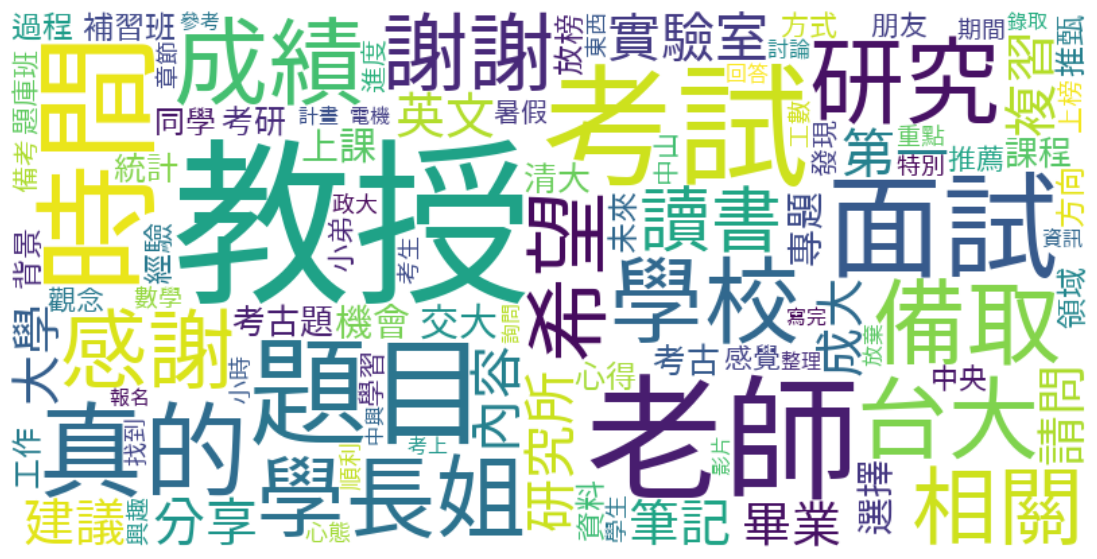

In [ ]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(march_2025_high_rating_df['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

教授、老師、學長姐：顯示在正面文章中，申請者常表達對教學人員與學長姐的感謝，可能涉及推薦信、指導、經驗分享等。<br>
考試、面試、題目：與升學過程中的準備與流程密切相關，說明正面文章多與「通過考試」或「順利面試」有關。

## 5. Text Clustering

In [ ]:
# metaData.to_pickle('metaData.pkl')

In [ ]:
metaData = pd.read_pickle('metaData.pkl')

In [ ]:
# 確保 artDate 是 datetime 格式
metaData['artDate'] = pd.to_datetime(metaData['artDate'])

# 設定日期範圍
start_date = pd.to_datetime("2025-03-01")
end_date = pd.to_datetime("2025-04-15")
filtered_df = metaData.dropna(subset=['sentence'])

# 篩選條件：日期在範圍內，且 artContent 同時包含「放榜」「面試」「口試」
filtered_df = metaData[
    (metaData['artDate'] >= start_date) &
    (metaData['artDate'] <= end_date) &
    (metaData['artContent'].str.contains("放榜", na=False))
]

# 取出 sentence 欄為 list，最多 5000 筆
docs_zh = filtered_df['sentence'].tolist()[:500]

# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
jieba.load_userdict('./dict/user_dict.txt')

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("google-bert/bert-base-chinese")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
hdbscan_model = HDBSCAN()

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    filtered = [w for w in words if len(w) > 1]
    return filtered

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

Building prefix dict from c:\Users\User\Desktop\VSCode_Workspace\Python\SM\SMA_2025S\week12\dict\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.ucf0dca050086923d0226dbed2978707f.cache
Loading model cost 0.647 seconds.
Prefix dict has been built successfully.
No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2025-05-07 20:03:46,296 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-07 20:03:46,921 - BERTopic - Dimensionality - Completed ✓
2025-05-07 20:03:46,922 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-07 20:03:46,932 - BERTopic - Cluster - Completed ✓
2025-05-07 20:03:46,934 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-07 20:03:46,979 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,142,-1_教授_題目_實驗室_分數,"[教授, 題目, 實驗室, 分數, 成績, 指考, 老師, 相關, 希望, 考試, 題庫, ...","[也順便介紹本系模擬實驗室兩位教授呂德老師老師是德國人, 寒假休息一週後我就開始準備考試信號..."
1,0,148,0_放榜_教授_台大_考試,"[放榜, 教授, 台大, 考試, 正取, 小弟, 研究所, 學校, 成績, 實驗室, 面試,...",[目前考試的大部分學校都放榜了希望大家都有上心儀的學校想問一下版上的各位大神會怎麼選擇呢小弟...
2,1,78,1_謝謝_資訊_幾次_想到,"[謝謝, 資訊, 幾次, 想到, 生活, 類比, 找到, 中央, 感謝, 焦慮, 真的, 狀...","[謝謝大家, 謝謝, 謝謝各位看完]"
3,2,70,2_老師_時間_東西_只能,"[老師, 時間, 東西, 只能, 能力, 英文, 論文, 人生, 資工碩, 感覺, 發現, ...",[到了第三年我開始寫論文每週都在改教授永遠都不滿意我感覺自己就是在打雜的寫個論文毛一堆同學跟...
4,3,35,3_分享_請問_學長_經驗,"[分享, 請問, 學長, 經驗, 希望, 意見, 一篇, 看法, 姐們, 大神, 想問, 心...","[希望有學長姐可以來分享一下, 因此決定在此也分享自身的經驗, 希望有學長姐們可以分享一下]"
5,4,14,4_讀博_春季班_數學系_岩壁,"[讀博, 春季班, 數學系, 岩壁, 有修, 書卷, 事後, 放飛, 插班, 輔系, 就會,...","[瑞典讀博, 美國讀博, 所以決定湊個數學系的事後輔系]"
6,5,13,5_下手_文筆_有始有終_會來,"[下手, 文筆, 有始有終, 會來, 最想, 實在, 問過, 流暢, 動機, 複查, 講不出...","[因為我比較想去電信乙所以老實說講不出什麼動機, 一開始不知道怎麼下手沒關係, 但我發現蠻多..."


In [ ]:
len(docs_zh)

500

In [ ]:
zh_topic_model.visualize_topics()

BERTopic 總共分出六個主題，像是有放榜、時間壓力、經驗分享等主題，主題之間重疊性較高

In [ ]:
# 估算每個文件對BERTopic每個主題的機率分布
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


In [ ]:
print(topic_distr[0])

[0.45320692 0.         0.         0.54679308 0.         0.        ]


In [ ]:
# 以第18個文件為例，列出這份文件對每個主題的機率分布
zh_topic_model.visualize_distribution(topic_distr[0])

In [ ]:
# 列出主題的代表詞和其對應的權重
zh_topic_model.get_topic(0)

[('放榜', 0.09496642532024784),
 ('教授', 0.07977732860824287),
 ('台大', 0.04553749418387911),
 ('考試', 0.03502884167990701),
 ('正取', 0.03463676928605411),
 ('小弟', 0.03375999130925248),
 ('研究所', 0.03375999130925248),
 ('學校', 0.03259482103999241),
 ('成績', 0.032429112966322865),
 ('實驗室', 0.03028328966363851),
 ('面試', 0.029294320464850598),
 ('考研', 0.024446115779994306),
 ('面談', 0.024446115779994306),
 ('還在', 0.023714446186871834),
 ('中興', 0.023714446186871834),
 ('學長', 0.023553669738385505),
 ('想問', 0.021795397585964767),
 ('中山', 0.021795397585964767),
 ('推甄', 0.019994776474492094),
 ('備取', 0.019777988826522937),
 ('發現', 0.019777988826522937),
 ('打算', 0.018971556949497467),
 ('領域', 0.018971556949497467),
 ('機會', 0.01813837432880915),
 ('信號', 0.01813837432880915),
 ('希望', 0.017514420839953505),
 ('專題', 0.017436318068771814),
 ('預期', 0.017436318068771814),
 ('焦慮', 0.016830223967976083),
 ('落榜', 0.016830223967976083)]

查看特定文章的主題分佈

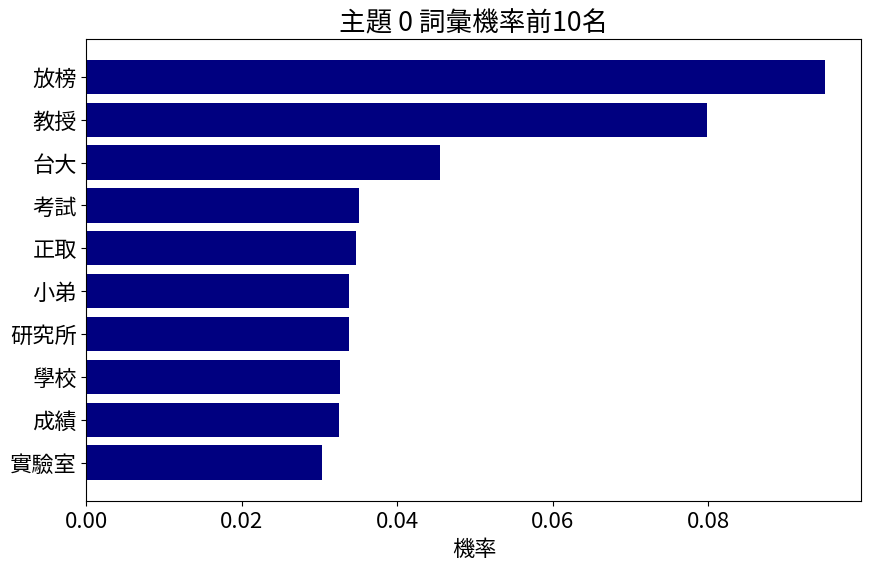

In [ ]:
# 視覺化顯示主題-詞彙分佈
topic_n = 0
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

##### KeyBERT

## 第一次Keybert(有問題)

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

# KeyBERT
keybert = KeyBERTInspired()

# 設定HDBscan模型
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=30)

# 定義我們要用到的representation model（同學如果想比較其他模型可以在這邊加入其他模型方法）
representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "MMR": MaximalMarginalRelevance(diversity=0.3)
}

In [ ]:
# 建立BERTopic模型
representation_topic_model = BERTopic(
  # Sub-models
  embedding_model=bert_sentence_model,
  vectorizer_model=jieba_vectorizer,
  # 設定Representation model
  representation_model=representation_model,
  # Hyperparameters
  top_n_words=30,
  verbose=True
)

# Train model
topics, probs = representation_topic_model.fit_transform(docs_zh, embeddings)

2025-05-07 20:33:28,283 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-07 20:33:28,902 - BERTopic - Dimensionality - Completed ✓
2025-05-07 20:33:28,903 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-07 20:33:28,912 - BERTopic - Cluster - Completed ✓
2025-05-07 20:33:28,913 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-07 20:33:30,681 - BERTopic - Representation - Completed ✓


In [ ]:
# 觀察KeyBERT微調後的主題表示
representation_topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,257,-1_教授_放榜_實驗室_台大,"[教授, 放榜, 實驗室, 台大, 成績, 考試, 研究所, 面試, 考研, 希望, 信號,...","[研究所, 沒什麼, 補習班, 老師, 請問, 謝謝, 電機系, 題目, 成績單, 考研]","[實驗室, 研究所, 考研, 題目, 指考, 春季班, 老師, 請問, 電信乙, 領域]","[考試生是不是根本不能選教授, 雖然知道有些教授考試前就滿了, 目前有興趣想面談的教授是胡敏..."
1,0,88,0_類比_資訊_幾次_家人,"[類比, 資訊, 幾次, 家人, 下手, 想到, 生活, 感謝, 焦慮, 謝謝, 感覺, 真...","[說真的, 蠻多人, 有始有終, 好不好, 沒關係, 獲益匪淺, 僅供參考, 對不起, 糟透...","[幾次, 謝謝, 感覺, 過得, 一團糟, 有始有終, 沒關係, 每周, 我線代, 意外]","[多寫幾次真的就會了, 我只知道跟類比完全不同, 是不是等於只能賭一把台聯大會上或是保守直接..."
2,1,37,1_小弟_教授_中興_機會,"[小弟, 教授, 中興, 機會, 放榜, 學校, 有沒有, 備取, 正取, 大神, 考試, ...","[成大想問, 指導教授, 研究所, 面對現實, 這兩校, 資管系, 三生有幸, 有沒有, 碩...","[有沒有, 正取, 大神, 想問, 面談, 網路上, 妹妹, 專業, 版上, 打算]",[等待放榜蠻焦慮的小弟成績不太好工數電磁書審知道這樣的成績正取不可能但不確定有沒有機會備取上...
3,2,34,2_分享_請問_學長_經驗,"[分享, 請問, 學長, 經驗, 希望, 意見, 一篇, 看法, 姐們, 心得, 想問, 有...","[這部分, 這一題, 有沒有, 解決辦法, 請教, 想問, 請問, 微不足道, 聽聽, 姐能給]","[請問, 想問, 抒發, 微不足道, 這部分, 聽聽, 解決辦法, 走來, 這一題, 加賴]","[希望有學長姐可以來分享一下, 因此決定在此也分享自身的經驗, 希望有學長姐們可以分享一下]"
4,3,28,3_時間_只能_論文_資工碩,"[時間, 只能, 論文, 資工碩, 人生, 發現, 感覺, 能力, 實驗, 痛苦, 覺醒, ...","[生不如死, 某種程度, 興趣愛好, 跟不上, 悲慘世界, 聽得懂, 絕大多數, 花太多, ...","[論文, 資工碩, 人生, 感覺, 每週, 跟不上, 悲慘世界, 這時候, 辦法, 暑期班]",[剛到實驗室的第一年我發現大家都比我強英文能力很好上課都聽得懂我英文授課都聽不懂只能修中文的...
5,4,21,4_放榜_成績_分數_預期,"[放榜, 成績, 分數, 預期, 正取, 推甄, 原本, 落榜, 上榜, 發現, 怪怪的, ...","[考試分數, 心路歷程, 殊不知, 離散數學, 怪怪的, 研究所, 考完試, 回家, 難過,...","[放榜, 預期, 怪怪的, 星期四, 明天, 殊不知, 考完試, 考試分數, 表定, 離散數學]","[今天中山開放查成績才發現我的離散數學分數好像怪怪的, 還說如果預期分數比往年低結果卻正取,..."
6,5,14,5_老師_不可多得_教學_英語,"[老師, 不可多得, 教學, 英語, 觀念, 老師上課, 理解, 溝通, 須用, 概念, 輔...","[老師上課, 聽不懂, 老師, 不可多得, 輔以, 平易近人, 標準, 居多, 學到, 放慢]","[不可多得, 觀念, 老師上課, 輔以, 填鴨式, 寫給, 居多, 平易近人, 標準, 聽不懂]","[老師很自由, 如果你聽不懂老師說的話老師會放慢或寫給你看, 需要注意的是老師的課跟呂德老師..."
7,6,11,6_報到_財金_台大_跨考,"[報到, 財金, 台大, 跨考, 錄取, 放榜, 沒前途, 理科, 理工科, 沒報, 求過,...","[理工科, 研究所, 財金系, 沒前途, 醫工, 考上, 考研, 同一天, 科系, 轉系]","[跨考, 沒前途, 理工科, 不歸路, 財金系, 轉系, 逢甲, 醫環, 電資選, 同一天]","[小弟我當初升大學時在頭上這間非正系理工科系和青椒電資選了前者, 本人理組跨考台大的政治所今..."
8,7,10,7_興趣_讀書_成就_睡覺,"[興趣, 讀書, 成就, 睡覺, 目標, 疫情, 洗澡, 睡醒, 對讀, 完事, 外面, 出...","[沒什麼, 回家, 一大群, 目標, 睡覺, 睡醒, 洗澡, 那年, 真的, 讀書]","[讀書, 睡覺, 目標, 疫情, 洗澡, 完事, 一大群, 那年, 回家, 沒什麼]","[如果對讀的東西有點興趣, 想吃的想去的以前喜歡的各種人事物也會失去興趣, 做完事馬上回家洗..."


In [ ]:
representation_topic_model.visualize_topics()

In [ ]:
# 估算每個文件對BERTopic每個主題的機率分布
topic_distr, _ = representation_topic_model.approximate_distribution(docs_zh)

100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


In [ ]:
# 列出主題的代表詞和其對應的權重
representation_topic_model.get_topic(0)

[('教授', 0.06564684690877363),
 ('放榜', 0.06373484648154588),
 ('老師', 0.0396947087129517),
 ('時間', 0.03010814674832609),
 ('成績', 0.029852207996797185),
 ('研究所', 0.028609212838832145),
 ('發現', 0.02709733207349348),
 ('正取', 0.026391141649223203),
 ('實驗室', 0.02577320517043768),
 ('面試', 0.025158619841423858),
 ('考研', 0.024782439373320916),
 ('學校', 0.024782439373320916),
 ('學長', 0.023195884653393912),
 ('小弟', 0.022887370271065716),
 ('真的', 0.022887370271065716),
 ('面談', 0.0216846344516558),
 ('考試', 0.021430091507612138),
 ('分數', 0.021075702723828263),
 ('預期', 0.019837342147630315),
 ('興趣', 0.01917200106291099),
 ('東西', 0.01793451962915325),
 ('只能', 0.01717305168904026),
 ('四大', 0.01717305168904026),
 ('學生', 0.016531118456358598),
 ('中山', 0.016531118456358598),
 ('想問', 0.016531118456358598),
 ('焦慮', 0.015976667552425824),
 ('上榜', 0.015489024608325573),
 ('覺醒', 0.01509537560666766),
 ('辦法', 0.01509537560666766)]

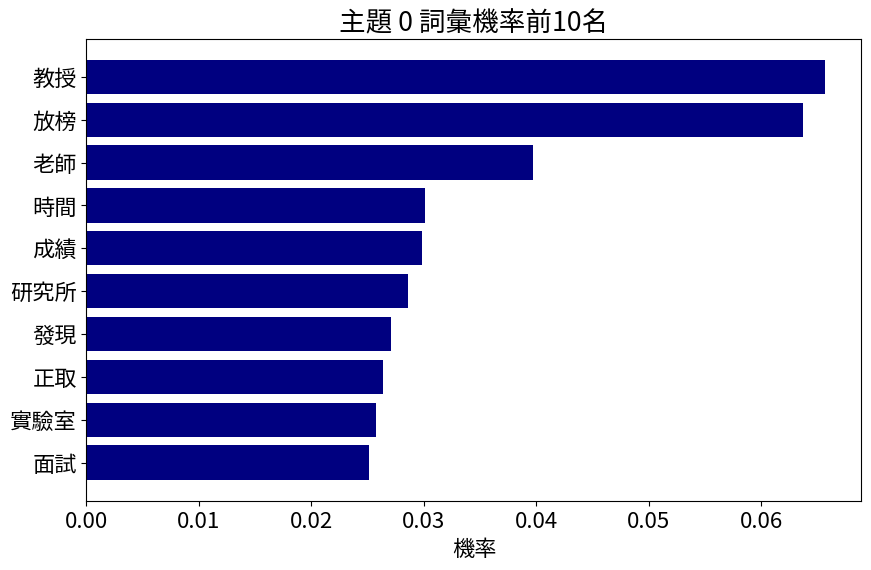

In [ ]:
# 視覺化顯示主題-詞彙分佈
topic_n = 0
data = representation_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

## 第二次Keybert

In [ ]:
from bertopic.representation import KeyBERTInspired
# KeyBERT
keybert = KeyBERTInspired()

# 設定HDBscan模型
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=30)

# 定義我們要用到的representation model（同學如果想比較其他模型可以在這邊加入其他模型方法）
representation_model = {
    "KeyBERT": keybert,
}

In [ ]:
# 建立BERTopic模型
representation_topic_model = BERTopic(
  # Sub-models
  embedding_model=bert_sentence_model,
  vectorizer_model=jieba_vectorizer,
  # 設定Representation model
  representation_model=representation_model,
  # Hyperparameters
  top_n_words=30,
  verbose=True
)

# Train model
topics, probs = representation_topic_model.fit_transform(docs_zh, embeddings)

2025-05-07 21:34:44,411 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-07 21:34:44,653 - BERTopic - Dimensionality - Completed ✓
2025-05-07 21:34:44,654 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-07 21:34:44,669 - BERTopic - Cluster - Completed ✓
2025-05-07 21:34:44,671 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-07 21:34:45,049 - BERTopic - Representation - Completed ✓


In [ ]:
# 觀察KeyBERT微調後的主題表示
representation_topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Representative_Docs
0,-1,174,-1_教授_信號_放榜_相關,"[教授, 信號, 放榜, 相關, 題目, 謝謝, 考研, 成績, 分數, 那種, 課程, 希...","[研究所, 線性代數, 電機系, 有沒有, 生機系, 請問, 老師, 實驗室, 考上, 數位]",[寒假休息一週後我就開始準備考試信號因為之前讀完了所以就刷一下課本的題目維持一下熟練度通原看...
1,0,199,0_放榜_教授_老師_面試,"[放榜, 教授, 老師, 面試, 成績, 台大, 時間, 考試, 發現, 正取, 小弟, 研...","[啊啊啊, 自我介紹, 研究所, 有沒有, 沒什麼, 想問, 打算, 考研, 網路上, 老師]",[目前考試的大部分學校都放榜了希望大家都有上心儀的學校想問一下版上的各位大神會怎麼選擇呢小弟...
2,1,80,1_類比_資訊_幾次_下手,"[類比, 資訊, 幾次, 下手, 家人, 想到, 選擇, 焦慮, 謝謝, 真的, 抽離, 文...","[說真的, 蠻多人, 沒什麼, 有始有終, 獲益匪淺, 沒關係, 僅供參考, 對不起, 這是...","[多寫幾次真的就會了, 選擇或類比的理由, 我只知道跟類比完全不同]"
3,2,33,2_分享_請問_經驗_學長,"[分享, 請問, 經驗, 學長, 希望, 意見, 一篇, 看法, 姐們, 心得, 想問, 有...","[這部分, 這一題, 有沒有, 解決辦法, 請教, 想問, 請問, 微不足道, 聽聽, 姐能給]","[希望有學長姐可以來分享一下, 希望有學長姐們可以分享一下, 因此決定在此也分享自身的經驗]"
4,3,14,3_實驗室_教授_競賽_面談,"[實驗室, 教授, 競賽, 面談, 融洽, 材光系, 傾向, 所有人, 思考, 佳作, 觀察...","[研究所, 機器人, 實驗室, 所有人, 請問, 老師, 材光系, 專題, 參加, 身為]","[我傾向要寄但我也還在思考進哪個教授的實驗室, 進不同的實驗室做研究不確定政治所的是否也需要..."


In [ ]:
representation_topic_model.visualize_topics()

共分成四個主題，相比第一次 BERTopic ，主題分布較分散、代表性更強，比較沒有主題之間區別模糊問題

In [ ]:
# 估算每個文件對BERTopic每個主題的機率分布
topic_distr, _ = representation_topic_model.approximate_distribution(docs_zh)

100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


In [ ]:
# 列出主題的代表詞和其對應的權重
representation_topic_model.get_topic(3)

[('實驗室', 0.4405085573996698),
 ('教授', 0.2869103416889155),
 ('競賽', 0.19255689791272493),
 ('面談', 0.15004796139705148),
 ('融洽', 0.11772327582561841),
 ('材光系', 0.11772327582561841),
 ('傾向', 0.11772327582561841),
 ('所有人', 0.11772327582561841),
 ('思考', 0.11772327582561841),
 ('佳作', 0.11772327582561841),
 ('觀察', 0.11772327582561841),
 ('跟系', 0.11772327582561841),
 ('學會', 0.11772327582561841),
 ('身為', 0.11772327582561841),
 ('離開', 0.11772327582561841),
 ('前輩', 0.11772327582561841),
 ('別校', 0.11772327582561841),
 ('政治', 0.10418050939297621),
 ('參加', 0.10418050939297621),
 ('提到', 0.10418050939297621),
 ('北部', 0.10418050939297621),
 ('田間', 0.10418050939297621),
 ('風氣', 0.10418050939297621),
 ('機器人', 0.10418050939297621),
 ('開口', 0.10418050939297621),
 ('經歷', 0.09627844895636246),
 ('呂德', 0.09627844895636246),
 ('模擬', 0.09627844895636246),
 ('實驗', 0.09068574143694648),
 ('研究', 0.09068574143694648)]

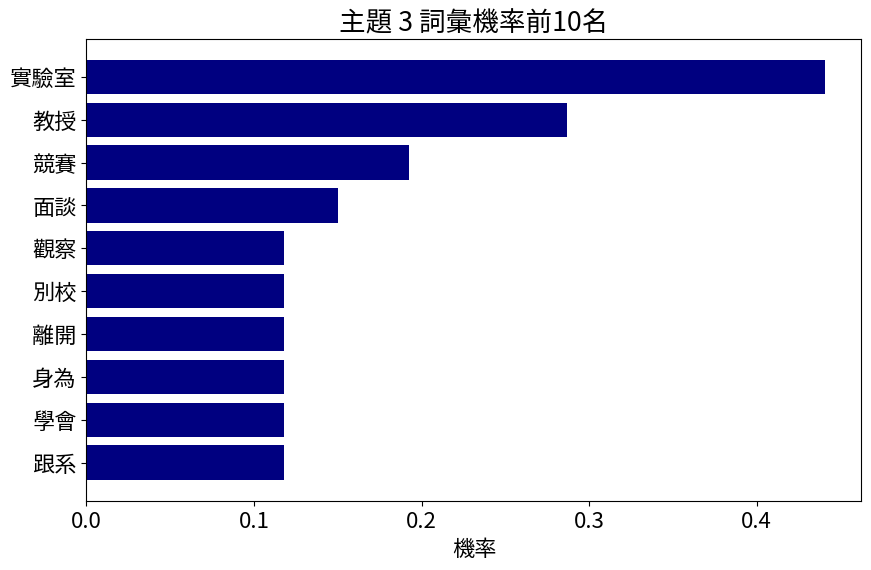

In [ ]:
# 視覺化顯示主題-詞彙分佈
topic_n = 3
data = representation_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

從高權重詞彙來看，主題 3 很可能與以下主題相關：

申請研究所時選擇實驗室與指導教授的經驗與觀察

從其他學校、其他實驗室轉換時的評估與心理歷程

參加競賽、面談等與錄取相關的關鍵經歷

對導師作風與實驗室氛圍的反思